In [84]:
import json
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from io_f import read_data_file
from main import calibrate_magnetic_wifi_ibeacon_to_position, extract_magnetic_strength

## Prepare environment and read data
Adopted from the sample code

In [85]:
selected_floor = 'B1'
floor_data_dir = f'./data/site1/{selected_floor}'
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = f'./output/site1/{selected_floor}'
path_image_save_dir = save_dir + '/path_images'
step_position_image_save_dir = save_dir
magn_image_save_dir = save_dir
wifi_image_save_dir = save_dir + '/wifi_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'
wifi_count_image_save_dir = save_dir
Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

In [86]:
with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

### Visualization of Waypoints

Han Yaodong

In [87]:
def visualize_path(path_id, waypoints, width_meter, height_meter):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.add_line(plt.Line2D(waypoints[:, 0], waypoints[:, 1], marker='.', color='grey'))
    for i, xy in enumerate(waypoints):
        ax.annotate(i + 1, xy)
    ax.set_title(f'Waypoints for {path_id} at Floor {selected_floor}')
    ax.set_xlim([0, width_meter])
    ax.set_ylim([0, height_meter])
    return fig

In [88]:
# reading data and visualize paths
waypoints_list = []
for path_filename in path_filenames:
    print(f'Processing file: {path_filename}...')

    path_data = read_data_file(path_filename)
    path_id = path_filename.name.split(".")[0]
    waypoints = path_data.waypoint[:, 1:3]
    waypoints_list.append(waypoints)
    
    # paths
    fig = visualize_path(path_id, waypoints, width_meter, height_meter)
    fig.savefig(f'{path_image_save_dir}/{path_id}.png')
    plt.close(fig)

Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda14979191710006b5720e.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda1499c5b77e0006b1752f.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda149dc5b77e0006b17531.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda149f9191710006b57212.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda14a2c5b77e0006b17533.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-location-competition-20-master\data\site1\B1\path_data_files\5dda14a39191710006b57214.txt...
Processing file: C:\Users\hanya\Desktop\AI6128\project1\indoor-l

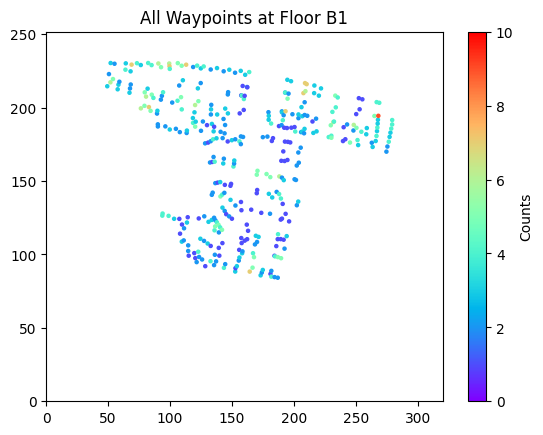

In [89]:
# visualize waypoints
all_waypoints = np.concatenate(waypoints_list)
unique_waypoints, counts = np.unique(all_waypoints, axis=0, return_counts=True)

fig = plt.figure()
ax = fig.add_subplot()
sc = plt.scatter(unique_waypoints[:, 0], unique_waypoints[:, 1], s=20, c=counts, marker='.', cmap='rainbow', vmin=0, vmax=10)
cbar = plt.colorbar(sc)
cbar.set_label("Counts")
ax.set_title(f'All Waypoints at Floor {selected_floor}')
ax.set_xlim([0, width_meter])
ax.set_ylim([0, height_meter + 20])
fig.savefig(f'{save_dir}/waypoints.png')

### Visualization of Geomagnetic Strength
Ben

In [ ]:
#The following function is developed to plot the different sets of GeoMagnetic Strength X,Y,Z at same position, in order to identify the outliners
def plot_sensor_info(df, name):
    cols = ["x", "y", "z"]
    plt.subplots(1, 1, sharex='col', sharey='row', figsize=(8,5))
    plt.suptitle(name, fontsize=22)
    plt.plot(df['time'], df['z'], color='#000000', label='z_axis')
    plt.plot(df['time'], df['y'], color='#d6b258', label='y_axis')
    plt.plot(df['time'], df['x'], color='#96bcfa', label='x_axis')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

   
def revised_extract_magnetic_strength(mwi_datas):
    magnetic_strength = {}
    for position_key in mwi_datas:
        magnetic_data = mwi_datas[position_key]['magnetic']
        df = pd.DataFrame(magnetic_data, columns=['time', 'x', 'y', 'z'])
        magnetic_s = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
        #
        #Below codes are to calculate if the X,Y,Z deviate too much across different measurement at same step positions, 
        #in order to identify noise
        #calculate mean and variance
        x_mean = np.mean(magnetic_data[:, 1])
        y_mean = np.mean(magnetic_data[:, 2])
        z_mean = np.mean(magnetic_data[:, 3])
        variance_magn_data=magnetic_data
        variance_magn_data[:, 1] -= x_mean
        variance_magn_data[:, 2] -= y_mean
        variance_magn_data[:, 3] -= z_mean
        variance_mean= np.mean(np.sqrt(np.sum(variance_magn_data[:, 1:4] ** 2, axis=1)))
        print("this is the position of below magnetic data measurement",position_key)
        print("variance is:",variance_mean)
        #
        #Set a threshold 4 such that if average variance of X,Y,Z greater than 4, 
        #such measurement is removed from the dataset, in order to create a clean and quality dataset for future training
        threshold=4
        if variance_mean < threshold:
           magnetic_strength[position_key] = magnetic_s
        #Enable line if need to capture the plot of outliner as it take long time to process 1000+ ploting.
        #if variance_mean >= threshold:
        #    #plot_sensor_info(df, "GeoMagnetic data")
        #
        #Enable below line instead of above if need to capture the plot of all X,Y,Z in different step positions
        #plot_sensor_info(df, "GeoMagnetic data")
    total_keys_before_cleanup = len(mwi_datas)
    total_keys_post_cleanup = len(magnetic_strength)
    print("total positions before cleanup are:",total_keys_before_cleanup, "total positions after removing variance>=4:",total_keys_post_cleanup)
    return magnetic_strength


In [ ]:
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position(path_filenames)

In [ ]:
#visualize magnetic heatmap before data cleanup

# Define global color scale limits so all heatmaps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
magnetic_strength = extract_magnetic_strength(mwi_datas)
position = np.array(list(magnetic_strength.keys()))
value = np.array(list(magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap before data cleanup"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()

this is the position of below magnetic data measurement (201.52284025458113, 49.32625133664084)
variance is: 2.8450832172144644
this is the position of below magnetic data measurement (201.5820943264456, 45.72576227652739)
variance is: 1.9687989657355132
this is the position of below magnetic data measurement (200.85252726113694, 43.30256508955301)
variance is: 1.632546376257088
this is the position of below magnetic data measurement (199.70978114509938, 40.34169187615168)
variance is: 2.1772714267791584
this is the position of below magnetic data measurement (198.63285988674156, 36.57305072187162)
variance is: 2.2371570142704726
this is the position of below magnetic data measurement (197.72217021522184, 33.74487612542141)
variance is: 2.767187338387546
this is the position of below magnetic data measurement (197.5282219028332, 30.935663746961755)
variance is: 1.6985482312393423
this is the position of below magnetic data measurement (197.84907893868805, 27.490999680693815)
variance i

this is the position of below magnetic data measurement (201.311997423595, 109.14749211718298)
variance is: 2.3395868683256165
this is the position of below magnetic data measurement (201.43170407937427, 108.58261061738077)
variance is: 1.9760167024509612
this is the position of below magnetic data measurement (201.5650566294721, 108.06055133540822)
variance is: 1.8650310587029353
this is the position of below magnetic data measurement (201.5747483929552, 107.06418829626153)
variance is: 1.6152630609605745
this is the position of below magnetic data measurement (200.6212219036535, 103.42896700552521)
variance is: 1.795175341237587
this is the position of below magnetic data measurement (199.42767, 95.57758)
variance is: 38.11973919183442
this is the position of below magnetic data measurement (197.94539193466952, 84.63210375837315)
variance is: 1.4883459418777067
this is the position of below magnetic data measurement (197.75022415245857, 83.98048069321106)
variance is: 1.7556300491008

this is the position of below magnetic data measurement (139.64458167570743, 63.92943380200553)
variance is: 2.859960642131717
this is the position of below magnetic data measurement (137.2462700092251, 61.65773157862499)
variance is: 2.687014115223891
this is the position of below magnetic data measurement (135.10643, 59.96784)
variance is: 10.42339698062424
this is the position of below magnetic data measurement (134.647943311616, 60.89838442387103)
variance is: 2.6304430536582974
this is the position of below magnetic data measurement (134.57941580046358, 64.69343279259637)
variance is: 1.682753660181781
this is the position of below magnetic data measurement (134.8603890656195, 66.05490359542428)
variance is: 7.085387033960106
this is the position of below magnetic data measurement (136.64202536534316, 66.49244973840818)
variance is: 5.190895931938717
this is the position of below magnetic data measurement (137.079689964407, 65.56144893354845)
variance is: 1.9755248390831255
this i

this is the position of below magnetic data measurement (97.96346570056099, 91.82138982889332)
variance is: 2.1261904915781327
this is the position of below magnetic data measurement (99.16686007989426, 92.59410906600793)
variance is: 2.879342536278458
this is the position of below magnetic data measurement (102.11307315663055, 91.4645127484988)
variance is: 2.1360108627488352
this is the position of below magnetic data measurement (104.15904271511918, 90.59619194016805)
variance is: 1.8786706430891704
this is the position of below magnetic data measurement (106.69401533400652, 89.42590182164618)
variance is: 1.768153002622902
this is the position of below magnetic data measurement (108.15181076386283, 89.18301485019558)
variance is: 6.565258991315717
this is the position of below magnetic data measurement (109.51410076717545, 90.37100175201687)
variance is: 1.5820417364816524
this is the position of below magnetic data measurement (110.01341305337363, 90.44061995282719)
variance is: 1

this is the position of below magnetic data measurement (77.382545, 107.006226)
variance is: 22.620603788643468
this is the position of below magnetic data measurement (77.96843644810427, 106.83747646278948)
variance is: 2.4674135592248487
this is the position of below magnetic data measurement (78.88978160498385, 106.46299503390135)
variance is: 1.8058606257636998
this is the position of below magnetic data measurement (80.19450894777557, 106.17694449916505)
variance is: 6.441501270320994
this is the position of below magnetic data measurement (80.46364238686208, 106.56539749364252)
variance is: 3.5151881345287648
this is the position of below magnetic data measurement (80.90525951378557, 108.3115608067421)
variance is: 2.8406870936449233
this is the position of below magnetic data measurement (81.00607337084881, 109.08014298366507)
variance is: 1.9988721178206916
this is the position of below magnetic data measurement (81.31262324266844, 111.5494306461343)
variance is: 1.625193957962

this is the position of below magnetic data measurement (184.6665390658707, 142.73560390791118)
variance is: 3.2766838085376513
this is the position of below magnetic data measurement (184.89797286404288, 143.37326059862067)
variance is: 3.70251356351515
this is the position of below magnetic data measurement (185.6668851773256, 145.3914910752603)
variance is: 2.218999323611992
this is the position of below magnetic data measurement (185.8592549720434, 156.60357749269642)
variance is: 4.138005403495941
this is the position of below magnetic data measurement (185.71349999799526, 156.18249435452657)
variance is: 4.4342743091709105
this is the position of below magnetic data measurement (185.6021817805972, 155.3442618009977)
variance is: 3.166797004878964
this is the position of below magnetic data measurement (185.27597270039672, 154.29196597044174)
variance is: 4.214505674970674
this is the position of below magnetic data measurement (185.1310495925298, 153.23642570252025)
variance is: 

this is the position of below magnetic data measurement (211.2438322286976, 113.69841260824253)
variance is: 2.50498781245629
this is the position of below magnetic data measurement (210.04912828387765, 113.58544434109686)
variance is: 2.356373614567954
this is the position of below magnetic data measurement (207.3542065660252, 112.98100961651339)
variance is: 2.6550767818431145
this is the position of below magnetic data measurement (204.8056708978985, 111.02529454048933)
variance is: 2.305623493072044
this is the position of below magnetic data measurement (203.76092843803156, 110.21666186778282)
variance is: 1.8206843036386906
this is the position of below magnetic data measurement (204.15683073606618, 111.38350881528608)
variance is: 1.883756721334637
this is the position of below magnetic data measurement (207.5414093511304, 110.19895901953782)
variance is: 2.9812260238778077
this is the position of below magnetic data measurement (213.95786370126416, 117.15982033913103)
variance 

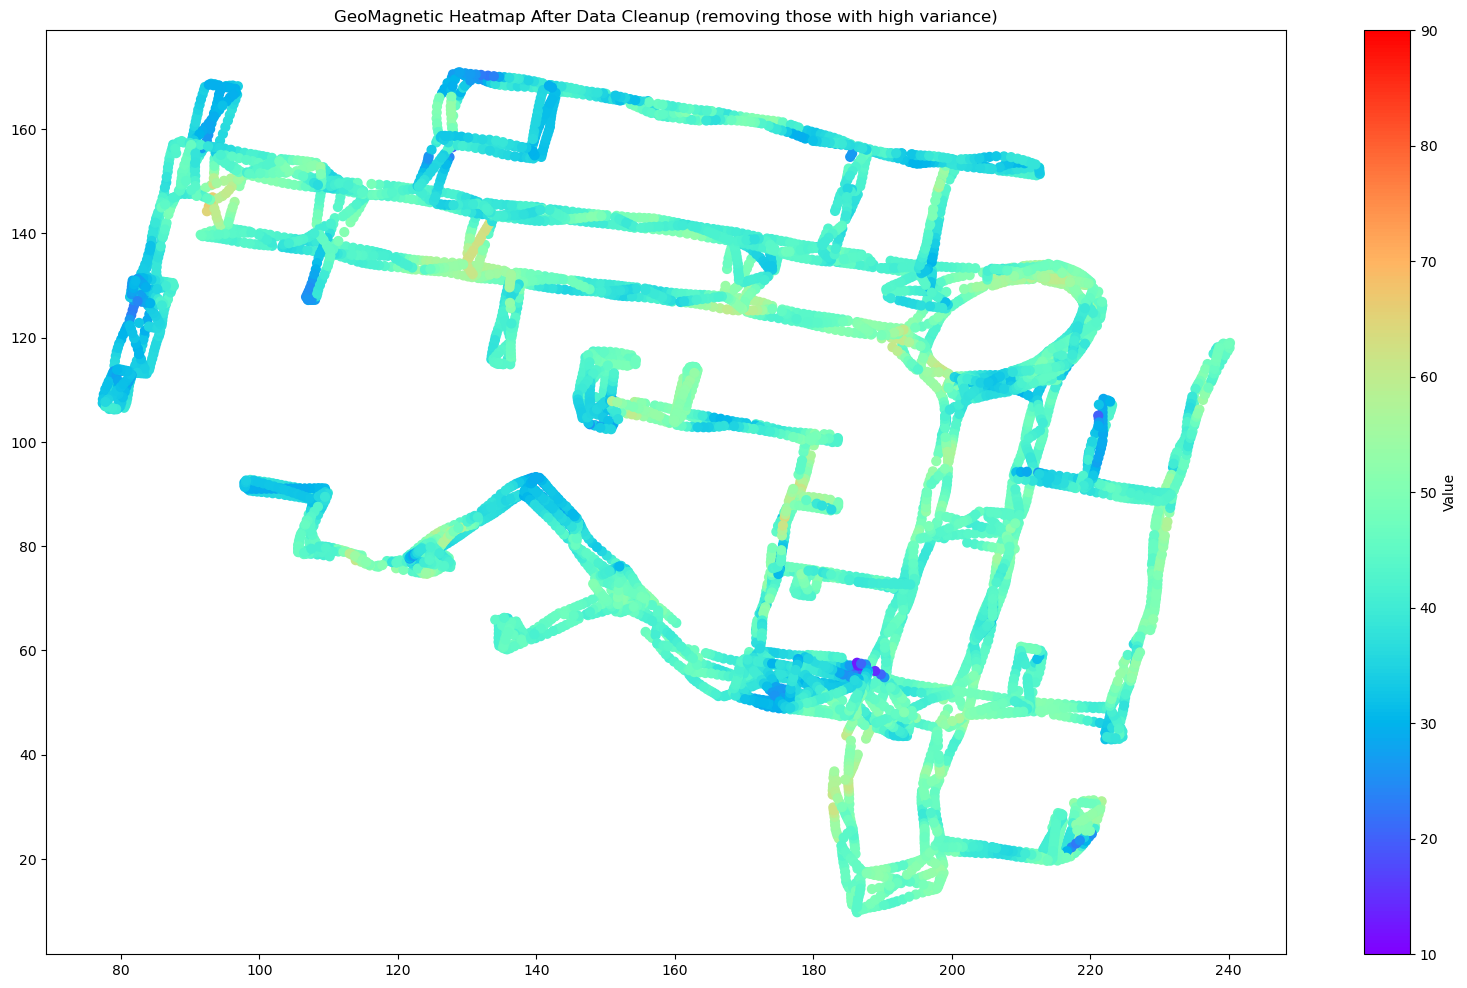

In [30]:
#visualize magnetic heatmap after data cleanup
#
# Define global color scale limits so all heat maps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
new_magnetic_strength = revised_extract_magnetic_strength(mwi_datas)
position = np.array(list(new_magnetic_strength.keys()))
value = np.array(list(new_magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap After Data Cleanup (removing those with high variance)"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()